In [1]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean

import gym
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import numpy as np
import matplotlib.pyplot as plt

## Let's Try Bayesian Optimization

#### Make Network

In [2]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [3]:
step_output = env.step(torch.randn(1))

In [4]:
step_output[0]

array([0.        , 1.        , 1.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       1.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 1.        , 1.03825137])

In [5]:
step_output[1]

-0.48673557704363746

#### set up phase

In [6]:
max_jump = 2.
n_start = 3
deltas = torch.rand(n_start) * 2*max_jump - max_jump
rwrds = torch.zeros(n_start)
for dind, dd in enumerate(deltas):
    rwrds[dind] = env.step(dd.unsqueeze(-1))[1].item()
    print(dd)


tensor(-1.4073)
tensor(-0.8224)
tensor(0.7452)


In [7]:
env.senders[0].get_run_data().get("recv rate")

1666877.890477401

In [8]:
output = env.step(dd.unsqueeze(-1))

In [9]:
output[0].shape

(30,)

In [10]:
deltas

tensor([-1.4073, -0.8224,  0.7452])

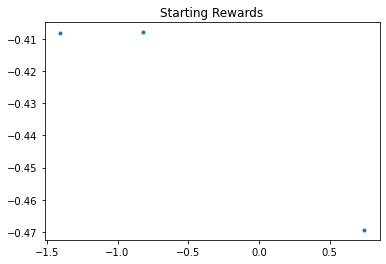

In [11]:
plt.plot(deltas, rwrds, marker='.', linestyle="None")
plt.title("Starting Rewards")
plt.show()

In [12]:
deltas

tensor([-1.4073, -0.8224,  0.7452])

In [13]:
bo = BayesOpt(deltas, rwrds, normalize=True, max_delta=max_jump, acquisition=expected_improvement)

In [14]:
rnds = 100
saved_rwrds = torch.zeros(rnds)
saved_deltas = torch.zeros(rnds)
test_points = torch.linspace(-max_jump, max_jump)
# test_points = torch.arange(1, 1000).float().div(max_x)
for ii in range(rnds):
    bo.train_surrogate(iters=200, overwrite=True)
    next_rate = bo.acquire(explore=0.01).unsqueeze(0)
#     print(next_rate.shape)
#     print("next rate = ", next_rate)
    rwrd = torch.tensor(env.step(next_rate)[1]).unsqueeze(0)
    saved_rwrds[ii] = rwrd.item()
    print(env.senders[0].get_run_data().get("recv rate"))
    bo.update_obs(next_rate, rwrd, max_obs=4)
    

1660816.7161211495
1720894.583134024
1610117.471503573
1666099.0545800591
1779886.5610182416
1921147.3991942964
1750564.2174992168
1635476.5777854435
1638364.7611601853
1505872.520654523
1525374.0879767241
1665799.8918996751
1666877.8904774045
1692682.4104035913
1779198.9574070836
1859079.824662665
1977651.734464717
1823678.7682226778
1779886.5610182453
1751634.3933830352
1592217.3599996623
1723382.2257478249
1836390.896288666
1657591.313353232
1610373.5552069838
1553869.2199365569
1437359.6354517364
1582121.387571767
1469112.7170309266
1480022.125738743
1666877.8904773975
1721717.753613714
1779198.539393926
1720069.784873094
1637579.903268644
1550394.70648501
1497364.8846661367
1522395.0349607375
1469112.7170309266
1412608.3817605062
1406248.9640473842
1525617.0523013468
1408233.271882342
1582121.387571767
1610116.696274074
1664471.0037910626
1776643.2122496401
1690250.9378607546
1638364.3483011147
1551126.9199309028
1469112.7170309266
1535591.1860030377
1412608.3817605062
1525617.052

In [15]:
saved_rwrds

tensor([-0.4757, -0.3311, -0.5313, -0.4702, -0.3466, -0.1225, -0.4541, -0.6620,
        -0.4171, -0.7306, -0.8738, -0.4705, -0.3874, -0.4412, -0.3473, -0.2607,
        -0.1331, -0.3711, -0.3466, -0.2991, -0.5499, -0.3285, -0.2108, -0.5584,
        -0.5310, -0.5928, -0.7208, -0.4757, -0.6860, -0.7606, -0.3874, -0.3303,
        -0.3473, -0.3320, -0.4179, -0.5087, -0.5640, -0.6272, -0.5934, -0.7484,
        -0.8476, -0.7100, -0.8455, -0.4757, -0.5313, -0.5512, -0.3500, -0.4437,
        -0.4171, -0.5080, -0.6860, -0.5242, -0.9300, -0.7100, -0.5310, -0.7291,
        -0.5985, -0.7484, -0.8779, -0.6228, -0.8792, -0.8740, -0.7261, -0.4757,
        -0.4187, -0.7461, -0.6860, -0.6473, -0.8747, -0.6228, -0.5992, -0.8740,
        -0.8512, -1.0854, -0.9694, -0.8032, -1.1444, -0.8877, -1.1325, -1.1959,
        -1.0979, -1.0370, -1.3934, -1.1231, -1.1069, -1.4677, -1.3291, -1.2445,
        -1.2409, -1.2468, -1.3291, -1.1277, -1.1046, -1.2954, -1.3291, -1.2441,
        -1.6223, -1.4340, -1.1526, -1.24